# Playa Potrero, Santa Cruz, Guanacaste (Zona Bosques 4). Junio 2011.

## Resumen

Este programa en Python recibe como entradas, para un área geográfica y un período de tiempo determinados:

- Un archivo CSV con datos de suelo (ej. capacidad de infiltración, densidad, profundidad de raíces, capacidad de campo).
- Un archivo CSV con datos mensuales meteorológicos de precipitación y evapotranspiración.

Como salida, el programa genera:
- Un modelo de balance hídirico de suelo basado en el método de Gunther Schosinsky {cite}`schosinsky_calculo_2006`, el cual muestra la recarga potencial de acuíferos, y otros datos relacionados, para cada mes del período en el área geográfica de estudio.

## Simbología

`fc`: Capacidad de Infiltración.  
`I`: Infiltración.  
`CC`: Capacidad de Campo.  
`PM`: Punto de Marchitez.  
`PR`: Profundidad de Raices.  
`(CC-PM)`: Rango de Agua Disponible.  
`DS`: Densidad de Suelo.  
`C1`: Factor de ETP, por cierre de estomas, antes que ocurra ETR.  
`C2`: Factor de ETP, por cierre de estomas, después que ocurre ETR.  
`Kp`: Factor por pendiente.  
`Kv`: Factor por vegetación.  
`Kfc`: Factor estimado con base a la prueba de infiltración. 
`P`: Precipitación Media Mensual.  
`Pi`: Precipitación que infilta.  
`ESC`: Escorrentía Superficial.  
`ETP`: Evapotranspiración Potencial.  
`ETR`: Evapotranspiración Real.  
`HSi`: Humedad de Suelo Inicial.  
`HD`: Humedad Disponible.  
`HSf`: Humedad de Suelo Final.  
`DCC`: Déficit de Capacidad de Campo.  
`Rp`: Recarga Potencial.  
`NR`: Necesidad de Riego.  
`Ret`: Retención de lluvia.

In [1]:
import math
import pandas as pd

## Datos de suelo

In [2]:
# Cálculos de textura

def kfc(row):
    if (row['fc'] < 16):
        return 0.0148*row['fc']/16
    else:
        if (row['fc'] > 1568):
            return 1
        else:
            return 0.267 * math.log(row['fc']) - 0.000154 * (row['fc']) - 0.723
        
def i(row):
    if (row['kp'] + row['kv'] + row['kfc'] > 1):
        return 1
    else:
        return row['kp'] + row['kv'] + row['kfc']
    
def cc_pm(row):
    return row['cc'] - row['pm']

In [3]:
textura = pd.read_csv("datos/textura.csv")

textura['kfc'] = textura.apply (lambda row: kfc(row), axis=1)
textura['i'] = textura.apply (lambda row: i(row), axis=1)
textura['cc_pm'] = textura.apply (lambda row: cc_pm(row), axis=1)

textura

,fc,kp,kv,kfc,i,ds,pr,hsi,cc,pm,cc_pm,mes_inicial,lluvia_retenida
0,18.41,0.06,0.1,0.051908,0.211908,1.35,3000,860,27,14.67,12.33,11,0.2


In [4]:
lluvia_retenida = textura.iloc[0, 12]
print("lluvia_retenida =", lluvia_retenida)

lluvia_retenida = 0.2


In [5]:
i = textura.iloc[0, 4]
print("i =", i)

i = 0.21190755673041148


In [6]:
mes_inicial = textura.iloc[0, 11]
print("mes_inicial =", mes_inicial)

mes_inicial = 11


In [7]:
hsi = textura.iloc[0, 7]
print("hsi =", hsi)

hsi = 860


## Datos meteorológicos

In [8]:
# Cálculos de meses

def ret(row):
    if (row['p'] <= 5):
        return row['p']
    else:
        if (row['p'] * lluvia_retenida > 5):
            return row['p']*lluvia_retenida
        else:
            return 5
        
def pi(row):
    return (row['p'] - row['ret']) * i

def esc(row):
    return row['p'] - row['ret'] - row['pi']

def etr(row):
    if (row['hd'] >= (row['c1'] + row['c2'])/2 * row['etp']):
        return (row['c1'] + row['c2'])/2 * row['etp']
    else:
        row['hd']
        
def rp(row):
    return row['pi'] + row['hsi'] - row['hsf'] - row['etr']

def nr(row):
    return row['dcc'] - row['etr'] + row['etp']

In [9]:
meses = pd.read_csv("datos/meses.csv")

meses['ret'] = meses.apply(lambda row:ret(row), axis=1)
meses['pi'] = meses.apply(lambda row:pi(row), axis=1)
meses['esc'] = meses.apply(lambda row:esc(row), axis=1)

meses['etr'] = meses.apply(lambda row:etr(row), axis=1)

meses['rp'] = meses.apply(lambda row:rp(row), axis=1)
meses['nr'] = meses.apply(lambda row:nr(row), axis=1)

## Modelo de balance hídrico

In [10]:
meses

,mes,p,ret,pi,esc,etp,hsi,c1,c2,hd,etr,hsf,dcc,rp,nr
0,1,298.00,59.600,50.518762,187.881238,139.15,796.490421,0.506391,0.365284,252.874183,60.646789,786.362394,307.137606,-1.421085e-13,385.640817
1,2,316.00,63.200,53.570230,199.229770,128.51,786.362394,0.492220,0.365549,245.797624,55.115972,784.816653,308.683347,-2.700062e-13,382.077376
2,3,153.71,30.742,26.057848,96.910152,148.91,784.816653,0.434030,0.304603,216.739501,54.994934,755.879567,337.620433,4.902745e-13,431.535499
3,4,139.00,27.800,23.564120,87.635880,149.42,755.879567,0.371089,0.260052,185.308687,47.152482,732.291206,361.208794,-8.455459e-13,463.476313
4,5,336.50,67.300,57.045514,212.154486,156.87,732.291206,0.390900,0.268103,195.201720,51.688891,737.647829,355.852171,5.542233e-13,461.033280
5,6,398.00,79.600,67.471366,250.928634,151.15,737.647829,0.422505,0.294619,210.984195,54.196667,750.922528,342.577472,-2.771117e-13,439.530805
6,7,387.25,77.450,65.648961,244.151039,155.32,750.922528,0.445439,0.306892,222.436489,58.425974,758.145515,335.354485,-4.263256e-13,432.248511
7,8,267.00,53.400,45.263454,168.336546,153.39,758.145515,0.419080,0.290351,209.273969,54.409844,748.999124,344.500876,4.334311e-13,443.481031
8,9,297.33,59.466,50.405179,187.458821,144.24,748.999124,0.411061,0.292327,205.269304,50.728324,748.675980,344.824020,8.526513e-14,438.335696
9,10,363.00,72.600,61.537954,228.862046,144.28,748.675980,0.432707,0.307687,216.078934,53.412022,756.801912,336.698088,9.237056e-14,427.566066


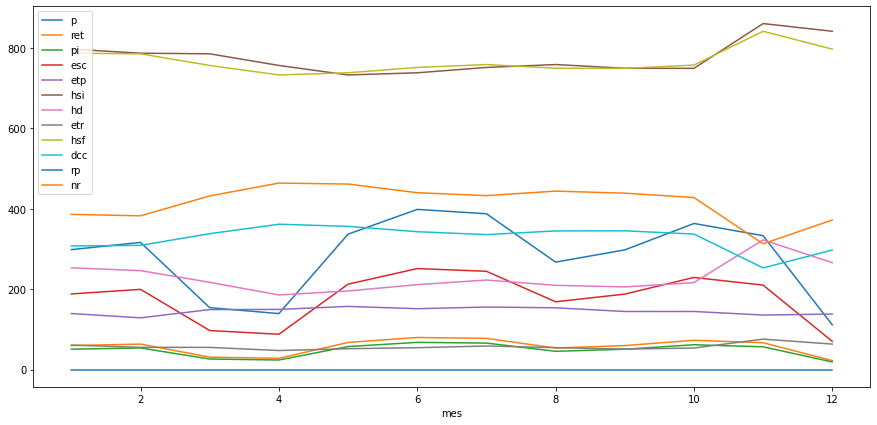

In [11]:
meses.plot(kind='line', x='mes', y=meses.columns[[1,2,3,4,5,6,9,10,11,12,13,14]], figsize=(15,7)).legend(loc='upper left')

## Referencias bibliográficas
```{bibliography}
:filter: docname in docnames
```